In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydaptivefiltering as pdf

In [2]:
# --- 1. CONFIGURAÇÃO DO CENÁRIO ---
np.random.seed(7)
n_samples = 1500
filter_order = 5  # 6 taps

# Entrada: Sinal colorido (AR process) para desafiar o algoritmo
# Sinais correlacionados degradam o LMS, mas o BNLMS lida bem com isso
x_white = (np.random.randn(n_samples) + 1j*np.random.randn(n_samples)) / np.sqrt(2)
x = np.zeros(n_samples, dtype=complex)
for i in range(1, n_samples):
    x[i] = 0.8 * x[i-1] + x_white[i] # Alta correlação

# Planta Desconhecida
w_true = np.array([0.2 - 0.3j, 0.5 + 0.1j, -0.4, 0.1, 0.05j, -0.1])

# Sinal desejado com ruído branco
noise_std = 0.02
d = np.zeros(n_samples, dtype=complex)
for k in range(len(w_true), n_samples):
    reg = x[k : k - len(w_true) : -1]
    d[k] = np.vdot(w_true, reg) + noise_std * (np.random.randn() + 1j*np.random.randn())

# --- 2. EXECUÇÃO DO FILTRO SM-BNLMS ---
# gamma_bar: deve ser ligeiramente superior à magnitude do ruído (e.g., 2 a 3x o std)
# gamma: pequeno valor de regularização (preveni divisão por zero)
filt_bnlms = pdf.SMBNLMS(
    filter_order=filter_order,
    gamma_bar=0.06,
    gamma=1e-6
)

result = filt_bnlms.optimize(x, d, verbose=True, return_internal_states=True)

[SM-BNLMS] Updates: 87/1500 | Runtime: 9.506 ms


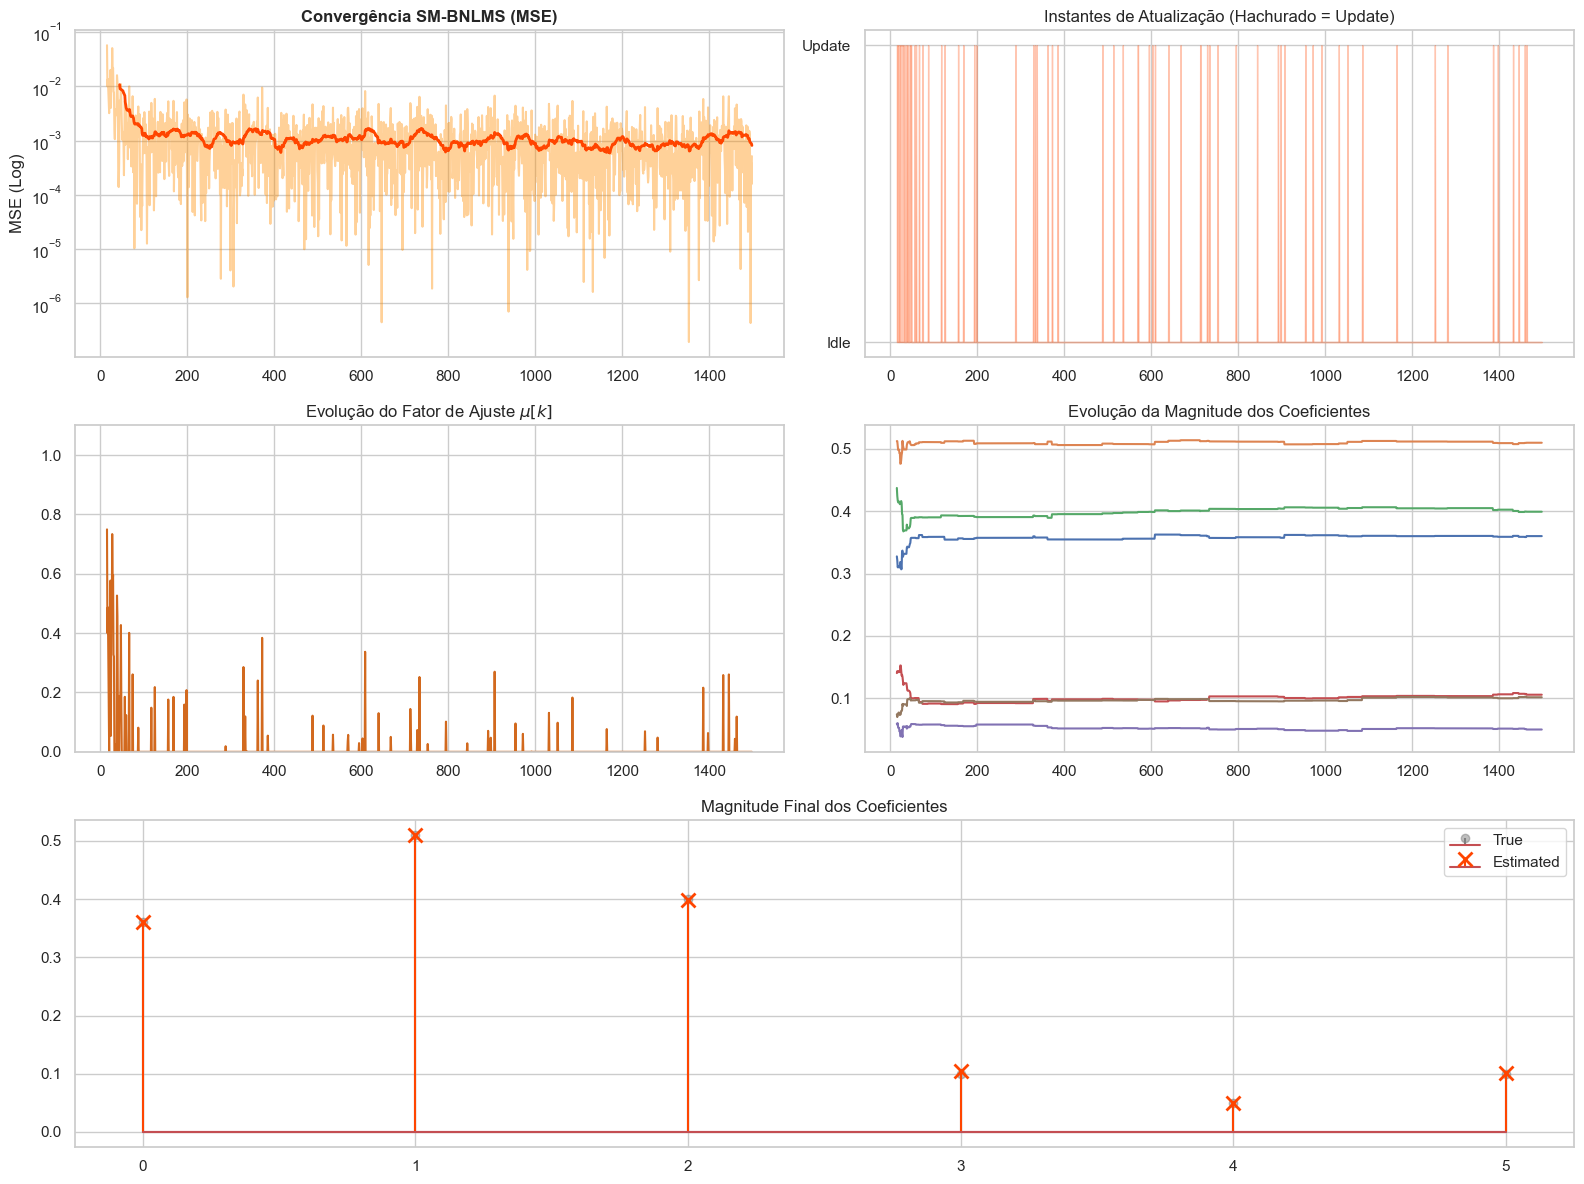

In [3]:
# --- 3. DASHBOARD DE DIAGNÓSTICO ---
def plot_sm_bnlms_dashboard(result, w_true, offset=15):
    sns.set_theme(style="whitegrid")
    
    mse = result.mse()[offset:]
    err_mag = np.abs(result.errors)[offset:]
    t = np.arange(len(result.mse()))[offset:]
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2)

    # A. Curva de Aprendizado (MSE)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.semilogy(t, mse, color='darkorange', alpha=0.4)
    ax1.semilogy(t, pd.Series(mse).rolling(30).mean(), color='orangered', lw=2)
    ax1.set_title("Convergência SM-BNLMS (MSE)", fontweight='bold')
    ax1.set_ylabel("MSE (Log)")

    # B. Atividade de Atualização (Update Mask)
    ax2 = fig.add_subplot(gs[0, 1])
    mask = result.extra['update_mask'][offset:]
    ax2.fill_between(t, 0, mask.astype(int), color='orangered', alpha=0.3)
    ax2.set_title("Instantes de Atualização (Hachurado = Update)")
    ax2.set_yticks([0, 1])
    ax2.set_yticklabels(['Idle', 'Update'])

    # C. Trajetória do Step-Size Variável (mu)
    ax3 = fig.add_subplot(gs[1, 0])
    mu = result.extra['mu'][offset:]
    ax3.plot(t, mu, color='chocolate')
    ax3.set_title(r"Evolução do Fator de Ajuste $\mu[k]$")
    ax3.set_ylim(0, 1.1)

    # D. Magnitude dos Pesos
    ax4 = fig.add_subplot(gs[1, 1])
    coeffs = np.abs(np.array(result.coefficients)[1:])[offset:]
    ax4.plot(t, coeffs)
    ax4.set_title("Evolução da Magnitude dos Coeficientes")

    # E. Comparação Final de Taps
    ax5 = fig.add_subplot(gs[2, :])
    w_final = result.coefficients[-1]
    
    m1, s1, b1 = ax5.stem(np.arange(len(w_true)), np.abs(w_true), linefmt='gray', markerfmt='o', label='True')
    m2, s2, b2 = ax5.stem(np.arange(len(w_true)), np.abs(w_final), linefmt='orangered', markerfmt='x', label='Estimated')
    plt.setp(m1, color='gray', alpha=0.5)
    plt.setp(m2, color='orangered', markersize=10, markeredgewidth=2)
    ax5.set_title("Magnitude Final dos Coeficientes")
    ax5.legend()

    plt.tight_layout()
    plt.show()

plot_sm_bnlms_dashboard(result, w_true)